# Configuration

In [57]:
# directory to store intermediate and final results of the experiment
EXPERIMENT_DIR                 = "/home/schindlera/experiments/ismir2020_reviews/"

METADATA_PATH                  = EXPERIMENT_DIR + "/experiment_partition.h5"
FEATURE_EXTRACTION_LOG_PATH    = EXPERIMENT_DIR + "/eval_trackids.csv"

VALIDATION_SPLIT_PERCENTAGE    = 0.05

# Imports

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# Load and Process Metadata

## Load Metadata

In [59]:
# Load Metadata
metadata_final         = pd.read_hdf(METADATA_PATH, "data")

# Load Feature Extraction Log
feature_extraction_log = pd.read_csv(FEATURE_EXTRACTION_LOG_PATH+ ".melspec_extract.log.csv", index_col=0)

In [63]:
metadata_final.shape, feature_extraction_log.shape, feature_extraction_log[feature_extraction_log.success].shape

((504992, 12), (504616, 2), (504616, 2))

## Reduce Metadata to successfully extracted Mel-Specs

In [64]:
metadata_final = metadata_final.loc[feature_extraction_log.index]

# Create Evaluation Partitions

## Util Functons

In [65]:
def get_least_frequent_genre(genre_list):

    vals = []

    for g in genre_list:

        g_idx = genre_frequencies.index.get_loc(g)

        vals.append([g_idx, g])

    vals = pd.DataFrame(vals, columns=["rank", "genre"]).sort_values("rank", ascending=False)
    
    return vals.iloc[0].genre

## Partition Data

### Pre-Process Labels to facilitate Stratification

### Original Distribution

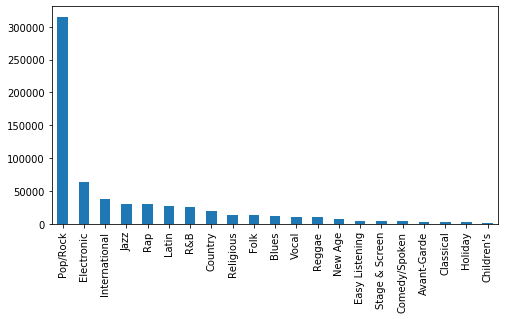

In [66]:
mlb = MultiLabelBinarizer()

experiment_genres = mlb.fit_transform(metadata_final.genres)
experiment_genres = pd.DataFrame(experiment_genres, index=metadata_final.index, columns=mlb.classes_)

genre_frequencies = experiment_genres.sum(axis=0).sort_values(ascending=False)
genre_frequencies.plot(kind='bar', figsize=(8,4));

## Flattened Distribution (only take least frequent tag)

In [67]:
processed_genres         = metadata_final.genres.apply(lambda x: get_least_frequent_genre(x))
processed_genres         = pd.DataFrame(processed_genres)
processed_genres.columns = ["genres_flattened"]

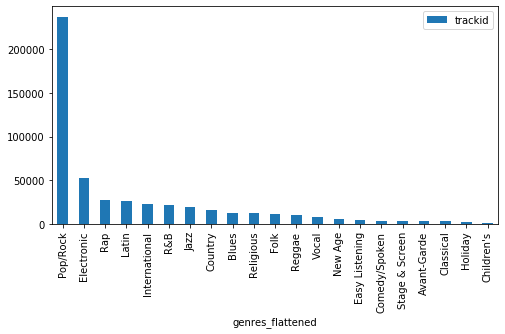

In [68]:
processed_genres.reset_index().groupby("genres_flattened").count().sort_values("trackid", ascending=False).plot(kind='bar', figsize=(8,4));

In [69]:
# join processed genres with final metadata
assert(metadata_final.shape[0] == processed_genres.shape[0])

metadata_final = metadata_final.join(processed_genres)

# Create Partitions

Numerically encode labels

In [70]:
encoder = LabelEncoder()
encoder = encoder.fit(metadata_final.genres_flattened)

genres_encoded = encoder.transform(metadata_final.genres_flattened)

create train/validation splits

In [71]:
sss                = StratifiedShuffleSplit(n_splits=1, test_size=VALIDATION_SPLIT_PERCENTAGE, random_state=0)

idx_train, idx_val = list(sss.split(np.ones(genres_encoded.shape[0]), genres_encoded))[0]

idx_train.shape[0], idx_val.shape[0]

(479385, 25231)

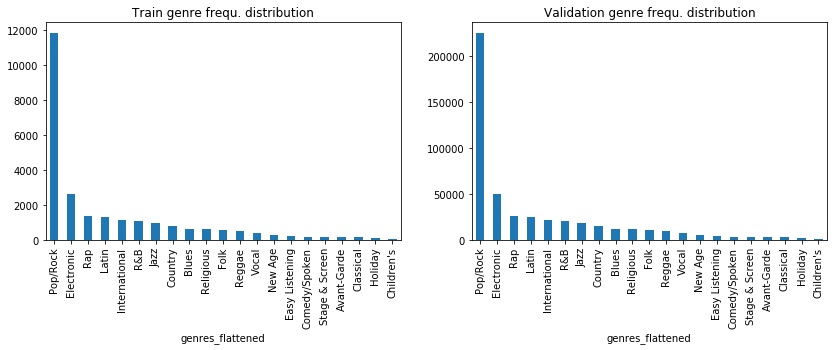

In [72]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
metadata_final.iloc[idx_val].reset_index().groupby("genres_flattened").count().sort_values("trackid", ascending=False).genres.plot(kind='bar', ax=ax1, title="Train genre frequ. distribution");
metadata_final.iloc[idx_train].reset_index().groupby("genres_flattened").count().sort_values("trackid", ascending=False).genres.plot(kind='bar', ax=ax2, title="Validation genre frequ. distribution");

Assign Partitions

In [73]:
metadata_final["train"] = False
metadata_final["val"]   = False

metadata_final.loc[metadata_final.iloc[idx_train].index, "train"] = True
metadata_final.loc[metadata_final.iloc[idx_val].index,   "val"]   = True

In [74]:
if not os.path.exists(EXPERIMENT_DIR):
    os.path.makedirs(EXPERIMENT_DIR)

In [75]:
metadata_final.to_hdf(EXPERIMENT_DIR + "/experiment_partition.h5", "data")

/home/schindlera/.conda/envs/base36/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['audio_path', 'genres', 'styles', 'moods', 'themes', 'artist_name',
       'title', 'release', 'reviews', 'genres_flattened'],
      dtype='object')]

  encoding=encoding,


# Create partition TrackID files for Feature extraction

Train Partition

In [37]:
metadata_final[metadata_final.train].reset_index()[["index", "audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_train.csv", header=None, index=None)

Validation Partition

In [38]:
metadata_final[metadata_final.val].reset_index()[["index","audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_val.csv", header=None, index=None)

All audio files

In [39]:
metadata_final.reset_index()[["index","audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_trackids.csv", header=None, index=None)

# ISMIR 2020 Paper Partitioning

The partitions for the ISMIR 2020 paper experiments are defined as follows:

* Experiment data is a subset of the Million Song Dataset. It has to conform to the following requirements
    * at least one AMG Genre tag is available 
    * a valid audio sample is available
* **Training partition** conforms to the following requirements
    * an album review is available
* **Validation partition**
    * 1% subset of the Training partiton
* **Test partition**
    * remaining tracks where no album reviews are available
    
Because the *Album Reviews Dataset* is a subset of the *AMG Tag-Set Dataset* all reviews should be include in the evaluation.

In [86]:
VALIDATION_SPLIT_PERCENTAGE = 0.01

In [76]:
# the previous steps have prepared the metadata - final checks

# at least one AMG Genre tag is available
assert(metadata_final.genres.isna().sum() == 0)

# a valid audio sample is available
# this has been garantued by the preceding processing pipeline - metadata has been synched with valid audio files

In [85]:
metadata_train = metadata_final[metadata_final.reviews == True]
metadata_test  = metadata_final[metadata_final.reviews != True]

# size of Train Partition (before validation split)
print("Train partition (incl. validation split): %d" % metadata_train.shape[0])
print("Test partition                          : %d" % metadata_test.shape[0])

Train partition (incl. validation split): 249980
Test partition                          : 254636


## Create Partitions

Numerically encode labels

In [87]:
encoder = LabelEncoder()
encoder = encoder.fit(metadata_final.genres_flattened)

genres_encoded = encoder.transform(metadata_train.genres_flattened)

create train/validation splits

In [90]:
sss                = StratifiedShuffleSplit(n_splits=1, test_size=VALIDATION_SPLIT_PERCENTAGE, random_state=0)

idx_train, idx_val = list(sss.split(np.ones(genres_encoded.shape[0]), genres_encoded))[0]


metadata_val       = metadata_train.iloc[idx_val]
metadata_train     = metadata_train.iloc[idx_train]

metadata_train.shape[0], metadata_val.shape[0]

(247480, 2500)

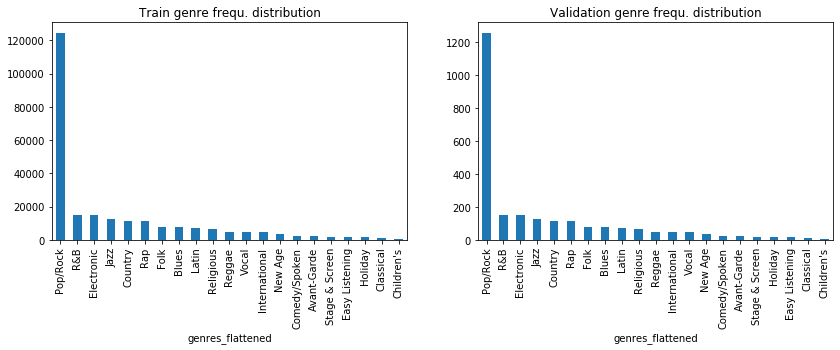

In [91]:
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
metadata_train.reset_index().groupby("genres_flattened").count().sort_values("trackid", ascending=False).genres.plot(kind='bar', ax=ax1, title="Train genre frequ. distribution");
metadata_val.reset_index().groupby("genres_flattened").count().sort_values("trackid", ascending=False).genres.plot(kind='bar', ax=ax2, title="Validation genre frequ. distribution");

Assign Partitions

In [100]:
metadata_final["train"] = False
metadata_final["test"]  = False
metadata_final["val"]   = False

metadata_final.loc[metadata_train.index, "train"] = True
metadata_final.loc[metadata_test.index,   "test"] = True
metadata_final.loc[metadata_val.index,     "val"] = True

In [92]:
if not os.path.exists(EXPERIMENT_DIR):
    os.path.makedirs(EXPERIMENT_DIR)

In [102]:
metadata_final.to_hdf(EXPERIMENT_DIR + "/experiment_partition.h5", "data")

/home/schindlera/.conda/envs/base36/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['audio_path', 'genres', 'styles', 'moods', 'themes', 'artist_name',
       'title', 'release', 'reviews', 'genres_flattened'],
      dtype='object')]

  encoding=encoding,


# Create partition TrackID files for Feature extraction

Train Partition

In [95]:
metadata_train.reset_index()[["trackid", "audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_train.csv", header=None, index=None)

Validation Partition

In [96]:
metadata_val.reset_index()[["trackid", "audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_val.csv", header=None, index=None)

Test Partition

In [97]:
metadata_test.reset_index()[["trackid", "audio_path"]].to_csv(EXPERIMENT_DIR + "/eval_partition_trackids_test.csv", header=None, index=None)